# Task 1: Causal Analysis of Game Design Impact on Player Engagement and Monetization

## Overview
This notebook aims to determine the more effective game design version — A or B — based on their impact on engagement (`n13`) and monetization (`n14`). Preliminary exploratory data analysis indicates that the assignment of players to groups A and B was non-random, with notable pre-test differences in engagement metrics like `n1`. These baseline discrepancies can potentially confound direct outcome comparisons.

## Objective
To provide an unbiased estimate of the causal impact of each game design on player behavior, we will employ causal inference techniques. These methods aim to adjust for confounding pre-test differences, enabling us to isolate the true effect of the game designs on post-test engagement and monetization.

The findings and final recommendations are summarized in the [Final Summary of Game Design Impact](#final_summary) section towards the end of this notebook.

### Note to Reviewers:
Please note that this notebook is intended as a working document that offers a transparent look at the analytical methods, rather than a polished report. It covers both  main analysis and additional exploratory and sensitivity analyses, included to show the depth of exploration. Section labeled "Sensitivity Analysis" are optional and focus on exploring different methods, they can be skipped for a focus on the main findings.  

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LinearRegression
import missingno as msno

In [3]:
df = pd.read_csv('../data/toydata_mltest.csv')

In [4]:
df.head()

,id,c1,c2,c3,c4,c5,c6,player_group,n1,n2,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,R0I,YW5kc,ZXM,NaN,True,LTA0OjAw,A,147.175163,508.833307,...,198.480790,1.513241e+09,0.877958,563.317119,18.827356,0.111096,0.910215,0.270997,38.999087,0.073268
1,1,QVI,aW9z,cHQ,aHVhd,True,KzAzOjAw,B,288.359771,1028.901212,...,384.252343,7.030908e+08,7.915538,1059.667759,NaN,0.360950,2.965243,0.349473,77.952363,0.185909
2,2,SVQ,aW9z,ZXM,NaN,True,LTA1OjAw,A,186.063223,650.402814,...,249.778061,5.050894e+09,1.573227,700.112963,NaN,0.155331,1.327952,0.140478,49.276629,0.097967
3,3,R0I,YW5kc,ZXM,NaN,True,LTA0OjAw,A,144.562911,499.384425,...,195.028589,2.703625e+09,0.843725,554.100930,NaN,0.108525,0.885378,0.152239,38.323737,0.071742
4,4,QlI,YW5kc,ZW4,YXBwb,True,NaN,A,77.314738,259.654122,...,105.726136,-1.728980e-01,0.274720,313.339044,10.028185,0.054445,0.363698,1.058591,21.585558,0.037120


In [5]:
group_metrics = df.groupby('player_group')[['n1','n13', 'n14']].describe()
group_metrics

n1                                                  \
                count        mean         std         min         25%   
player_group                                                            
A             35280.0   77.766107   80.046706   -1.000000    7.597781   
B             14720.0  586.641171  398.381076  276.182156  363.077131   

                                                       n13              ...  \
                     50%         75%          max    count        mean  ...   
player_group                                                            ...   
A              48.303494  132.979942   276.174109  35280.0   21.820021  ...   
B             479.858992  673.456624  9147.840007  14720.0  158.714401  ...   

                                           n14                              \
                     75%          max    count          mean           std   
player_group                                                                 
A              35.352569    74.444739  35280.0  4.191779e-02  4.452804e-02   
B             185.994554  2307.458796  14720.0  5.959413e+09  6.695068e+11   

                                                                    
                   min       25%       50%       75%           max  
player_group                                                        
A             0.000001  0.006444  0.024295  0.065159  1.732890e-01  
B             0.173297  0.279915  0.504498  1.234959  8.112489e+13  

[2 rows x 24 columns]

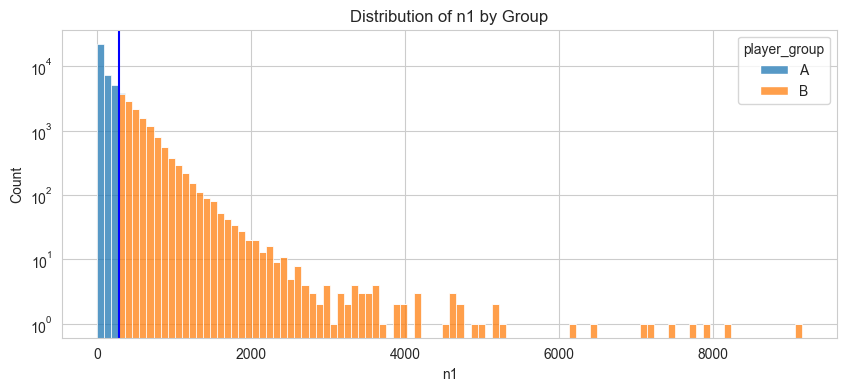

In [6]:
# Distribution plots for each group
for feature in ['n1']:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=feature, hue='player_group', stat='count', common_norm=False, bins=100, multiple='stack')
    plt.title(f'Distribution of {feature} by Group')
    plt.axvline(group_metrics.loc['A']['n1']['max'], color='blue')
    # plt.axvline(group_metrics.loc['B']['n1']['min'], color='orange')
    plt.yscale('log')
    plt.show()

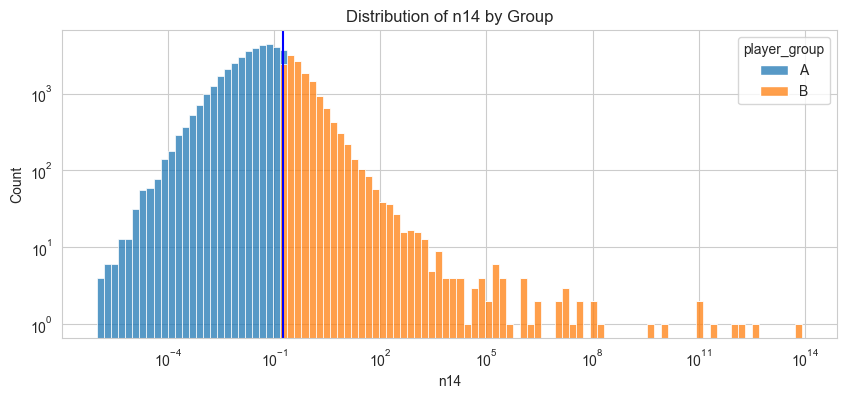

In [7]:
# Distribution plots for each group
for feature in ['n14']:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=feature, hue='player_group', stat='count', common_norm=False, bins=100, multiple='stack', log_scale=True)
    plt.title(f'Distribution of {feature} by Group')
    plt.axvline(group_metrics.loc['A']['n14']['max'], color='blue')
    plt.yscale('log')
    plt.show()

## Linear Regression Covariate Adjustment

**Objective**: Estimate the causal effect of game design versions (A or B) on engagement (`n13`) and monetization (`n14`), while adjusting for baseline characteristics to control for non-random group assignment.

**Method**: We will use linear regression, modeling `n13` and `n14` as functions of the treatment group and selected covariates. The treatment effect is quantified by the coefficient of the group variable (A or B), adjusted for these covariates.

### Key Assumptions:
- **Linearity**: The relationship between the outcome and predictors is linear.
- **No omitted variable bias**: All relevant confounders are included to prevent bias.
- **Independence**: Each observation is independent.
- **Homoscedasticity**: Constant variance of errors across observations.

### Model Considerations:
- **Interaction Terms**: If the treatment effect might vary by player characteristics (e.g., initial engagement level), an interaction term will be included.
- **Covariate Selection**:
  - **Inclusion**: We include `n1` for pre-test engagement due to its strong correlation with outcomes.
  - **Multicollinearity**: n1 is highly correlated with n2, n5, and n8. Including all these variables in the regression model could lead to multicollinearity, which would make the estimates of the model coefficients unstable and difficult to interpret. Given that `n1` represents pre-test engagement, I will assume it is the most relevant / strongly correlated with n13, and choose to retain n1 and omit the others.
  - **Low correlation**: variables n3, n4, n10, and n12 have demonstrated negligible correlation with both the treatment assignment and the outcomes (n13 and n14). Including these variables in our model would not contribute to explaining variance in the outcome and could unnecessarily complicate the model. 
  - **Omitting n9**: n9 has 95% missing values
  - Remaining variables (`n6`, `n7`, `n11`) and relevant categorical features are considered based on their contribution to explaining the outcome variance.

## Regression Analysis for Engagement (`n13`)

### Standard OLS Regression
We start with a basic OLS regression to establish a baseline for comparison.

In [13]:
## WITHOUT TREATMENT INTERACTION

# Normalize n1 and n13 as daily averages
df['n1_daily'] = df['n1'] / 30  # Pre-test engagement
df['n13_daily'] = df['n13'] / 7  # During-test engagement

# Create a binary indicator for player_group with 'B' as 1 and 'A' as 0
df['treatment_group'] = (df['player_group'] == 'B').astype(int)

# Set up the regression model with n13 as the dependent variable
X = df[['n1_daily', 'treatment_group', 'n7', 'n6', 'n8', 'n11']]  # Include other covariates as necessary
y = df['n13_daily']
X = sm.add_constant(X) 

model = sm.OLS(y, X)
results = model.fit()

# Print out the summary of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              n13_daily   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.630e+07
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        23:55:48   Log-Likelihood:                 14271.
No. Observations:               50000   AIC:                        -2.853e+04
Df Residuals:                   49993   BIC:                        -2.847e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1299      0.001    1

### Exploring Interaction Effects
Next, we include interaction terms to check if the treatment effect varies with initial engagement levels.

In [60]:
# Adding interaction terms
df['treatment_n1_daily'] = df['n1_daily']*df['treatment_group']

# Set up the regression model with n13 as the dependent variable
X = df[['n1_daily', 'treatment_group', 'treatment_n1_daily', 'n7', 'n6', 'n8', 'n11']]  # Include other covariates as necessary
y = df['n13_daily']
X = sm.add_constant(X) 

model = sm.OLS(y, X)
results = model.fit()

# 
# # Print out the summary of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              n13_daily   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.523e+07
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        00:37:19   Log-Likelihood:                 28617.
No. Observations:               50000   AIC:                        -5.722e+04
Df Residuals:                   49992   BIC:                        -5.715e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2311      0

### Interpreting the Results with and without Interaction Term

Model without Interaction Term:

- **Without Interaction Term**: The positive coefficient for `treatment_group` in the simple OLS model suggests that, on average, players in treatment group B exhibit higher outcomes compared to those in group A. This model assumes a uniform treatment effect across all levels of pre-test engagement.
  
- **With Interaction Term**: Incorporating the interaction term (`treatment_n1_daily`) reveals that the treatment effect is not uniform. The negative coefficient for `treatment_group` indicates a possible negative effect of being in group B for players with lower initial engagement. However, a positive coefficient for the interaction term indicates that this negative effect lessens or turns positive as initial engagement levels increase, demonstrating that the treatment effect depends on how engaged players were at the start.


### Robust Regression Analysis
Given the highly skewed distributions of both engagement (`n13`) and monetization (`n14`) metrics, where a subset of players—often referred to as 'power players'—demonstrate extreme values, a standard OLS regression may not provide the most accurate estimates. These power players are not outliers in the traditional sense but are integral to understanding overall player behavior, as they represent a significant albeit unique segment of the user base.

Robust regression minimizes the influence of these extreme cases without ignoring their impact. This method, including techniques like Huber regression, modifies the regression process to lessen the effect of outliers, potentially providing more reliable estimates that are not disproportionately swayed by these extremes.

In [61]:
# Robust Regression 

df['log_n11'] = np.log1p(df['n11'])

# Set up the regression model with n13 as the dependent variable
# X = df[['n1_daily', 'treatment_group', 'n7', 'n6', 'n8', 'n11']]  # without interaction
X = df[['n1_daily', 'treatment_group', 'treatment_n1_daily', 'n7', 'n6', 'n8', 'n11']]  # with interaction
y = df['n13_daily']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Robust regression model
robust_model = sm.RLM(y, X).fit()

# Print out the summary of the regression model
print(robust_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:              n13_daily   No. Observations:                50000
Model:                            RLM   Df Residuals:                    49992
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 13 May 2024                                         
Time:                        00:37:29                                         
No. Iterations:                    50                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2164      0

## Comparison of OLS and Robust Regression Results


- **Coefficient Consistency**: Across both models, the signs of the coefficients remain consistent. This suggests that the relationships between variables (such as treatment groups and engagement levels) and outcomes are stable, indicating robustness against the presence of outliers or influential observations.

- **Coefficient Magnitudes**: There are notable differences in the magnitude of coefficients between the models. For instance, the coefficient for `treatment_group` is considerably more negative in the robust model (-0.5905) than in the OLS model (-0.3027). This indicates a stronger adverse effect of design B when robust assumptions are applied. Such differences may stem from how the robust regression diminishes the influence of outliers, which, since they are all in group B, could skew the OLS estimates towards underestimating the negative impacts of design B.

- **Treatment Interaction**: The interaction term `treatment_n1_daily` consistently shows a positive effect in both models, yet it is more pronounced in the robust regression. This may suggest that the OLS model slightly underestimates this positive interaction due to outliers in group B, which also could distort the baseline treatment effect.

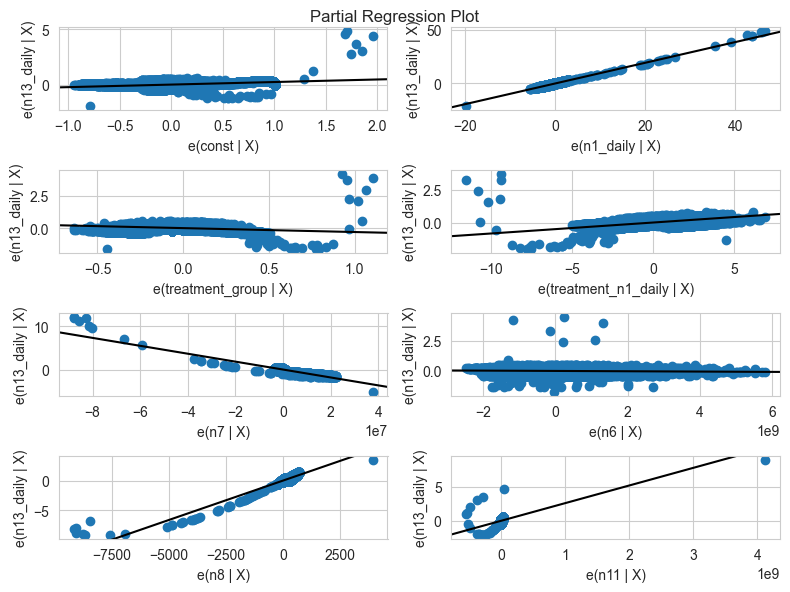

In [24]:
from statsmodels.graphics.regressionplots import plot_partregress_grid

# Assume 'model' is your fitted OLS model
fig = plt.figure(figsize=(8, 6))
plot_partregress_grid(robust_model, fig=fig)
plt.show()

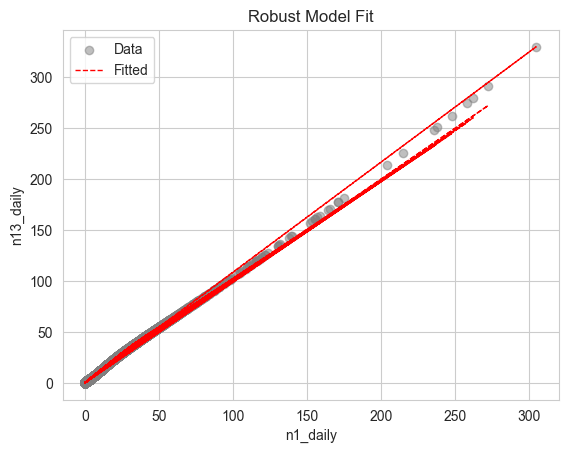

In [25]:
plt.scatter(df['n1_daily'], y, color='grey', alpha=0.5, label='Data')
plt.plot(df['n1_daily'], robust_model.fittedvalues, color='red', label='Fitted', linewidth=1, linestyle='--')
plt.xlabel('n1_daily')
plt.ylabel('n13_daily')
plt.title('Robust Model Fit')
plt.legend()
plt.show()

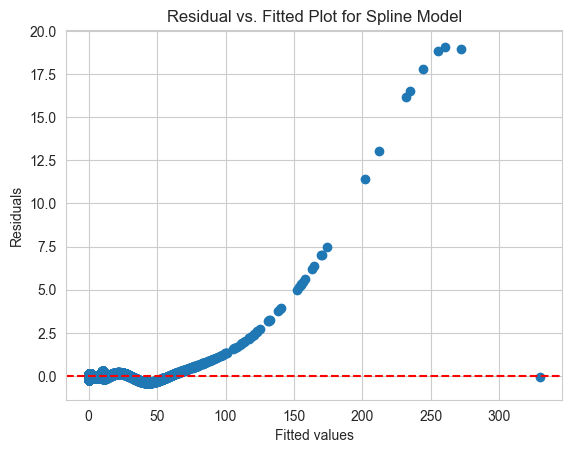

In [68]:
residuals = robust_model.resid
fitted = robust_model.fittedvalues

plt.scatter(fitted, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Plot for Spline Model')
plt.show()

In [38]:
### Include all categorical variables 
model_c = smf.rlm(formula="n13_daily ~ n1_daily + treatment_group + treatment_n1_daily + n7 + n6 + n8 + n11 + c1 + c2 + c3 + c4 + c5", data=df).fit()

print(model_c.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:              n13_daily   No. Observations:                32442
Model:                            RLM   Df Residuals:                    32250
Method:                          IRLS   Df Model:                          191
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 13 May 2024                                         
Time:                        00:19:23                                         
No. Iterations:                    50                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.8157      0

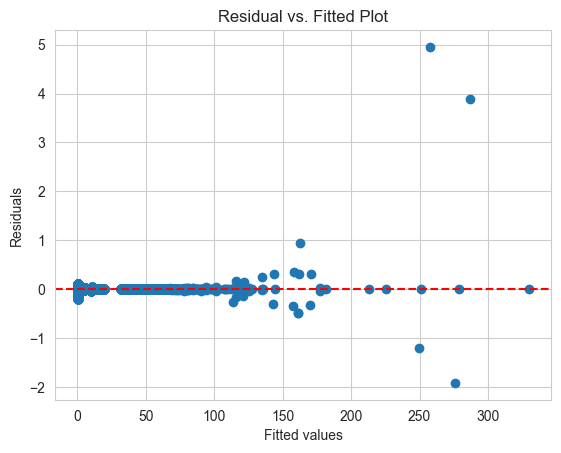

In [39]:
# Check residuals
residuals = model_c.resid
fitted_values = model_c.fittedvalues

# Plotting the residuals
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

## Regression Analysis for Engagement (`n14`)

Due to the highly skewed distribution of n14, we log-transform it for the regression.

### Standard OLS Regression
We start with a basic OLS regression to establish a baseline for comparison.

In [64]:
# Set up the regression model with n14 as the dependent variable

df['log_n14'] = np.log(df['n14'])
X = df[['n1_daily', 'treatment_group', 'n7', 'n6', 'n8', 'n11']]  # Include other covariates as necessary
y = df['log_n14']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# model_n14 = sm.OLS(y, X).fit(cov_type='HC3')
model_n14 = sm.OLS(y, X).fit()

# Print out the summary of the regression model
print(model_n14.summary())

                            OLS Regression Results                            
Dep. Variable:                log_n14   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                 3.884e+04
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        00:41:05   Log-Likelihood:                -72392.
No. Observations:               50000   AIC:                         1.448e+05
Df Residuals:                   49993   BIC:                         1.449e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.9688      0.007   -7

### Exploring Interaction Effects
Next, we include interaction terms to check if the treatment effect varies with initial engagement levels.

In [63]:
X = df[['n1_daily', 'treatment_group', 'treatment_n1_daily', 'n7', 'n6', 'n8', 'n11']]  # Include other covariates as necessary
y = df['log_n14']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# model_n14 = sm.OLS(y, X).fit(cov_type='HC3')
model_n14 = sm.OLS(y, X).fit()

# Print out the summary of the regression model
print(model_n14.summary())

                            OLS Regression Results                            
Dep. Variable:                log_n14   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 5.334e+04
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        00:40:57   Log-Likelihood:                -62323.
No. Observations:               50000   AIC:                         1.247e+05
Df Residuals:                   49992   BIC:                         1.247e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.4680      0

### Robust Regression Analysis

In [54]:
## Robust model n14
X = df[['n1', 'treatment_group', 'treatment_n1_daily', 'n7', 'n6', 'n8', 'n11']]  # Include other covariates as necessary
y = df['log_n14']
X = sm.add_constant(X)  # Adds a constant term to the predictor

robust_model_n14 = sm.RLM(y, X).fit()
# Print out the summary of the regression model
print(robust_model_n14.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                log_n14   No. Observations:                50000
Model:                            RLM   Df Residuals:                    49992
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 13 May 2024                                         
Time:                        00:26:39                                         
No. Iterations:                    50                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.9873      0

## Summary of Regression Analysis for Monetization (n14)

### Key Findings
- **Standard OLS Regression**: The initial model without the interaction term indicated a negative coefficient for the `treatment_group`, suggesting that being in group B is associated with lower monetization compared to group A when other variables are held constant.

- **OLS Regression with Interaction Term**: Introducing the interaction term (`treatment_n1_daily`) reversed some of the effects observed in the standard model. The coefficient for `treatment_group` became positive, while the interaction term was negative. This suggests that the effect of being in group B is more complex and varies with the players' pre-test engagement levels—specifically, it could be beneficial at certain levels of engagement.

- **Robust Regression**: The robust model confirmed the patterns observed in the OLS with interaction term, showing consistent signs across the coefficients but with some differences in magnitude. This consistency strengthens the credibility of our findings, underscoring the robustness of the model against outliers and influential observations.


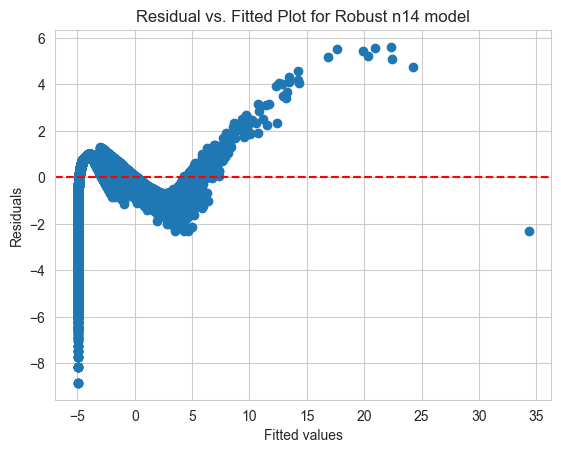

In [67]:
residuals = model_n14.resid
fitted = model_n14.fittedvalues

plt.scatter(fitted, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Plot for OLS n14 model')
plt.show()

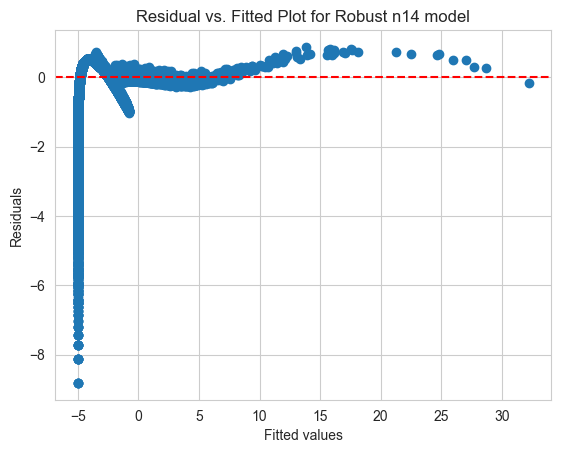

In [66]:
residuals = robust_model_n14.resid
fitted = robust_model_n14.fittedvalues

plt.scatter(fitted, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Plot for Robust n14 model')
plt.show()

## Residual Analysis for Robust Regression Model of Monetization (n14)

The residual plot for the robust regression model provides important diagnostics for the regression assumptions:

- **Homoscedasticity**: While there is no apparent fanning or systematic widening in the residuals, which generally supports the assumption of constant variance, there are clusters and some noticeable outliers, particularly for lower fitted values. This could indicate potential model misspecification or the need for further investigation into these specific cases.

- **Linearity**: The clustering of residuals at certain fitted value ranges and the sharp deviations, particularly on the left side of the plot, may suggest that the relationship between the predictors and the response variable could be non-linear or that influential outliers are affecting the model fit.

- **Outliers**: The presence of several outliers, especially at the lower end of fitted values, underscores the importance of robust regression techniques in this analysis, as these outliers could have a significant impact on the standard OLS regression results.

This plot highlights the need for potentially re-evaluating the model's fit, considering transformation of variables, or exploring non-linear models to better capture the underlying relationships and improve model assumptions adherence.


In [59]:
### Include all categorical variables 

model_c = smf.rlm(formula="log_n14 ~ n1_daily + treatment_group + treatment_n1_daily + n7 + n6 + n8 + n11 + c1 + c2 + c3 + c4 + c5 + c6", data=df).fit()

print(model_c.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                log_n14   No. Observations:                27644
Model:                            RLM   Df Residuals:                    27423
Method:                          IRLS   Df Model:                          220
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 13 May 2024                                         
Time:                        00:32:55                                         
No. Iterations:                    50                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            112.2728      0

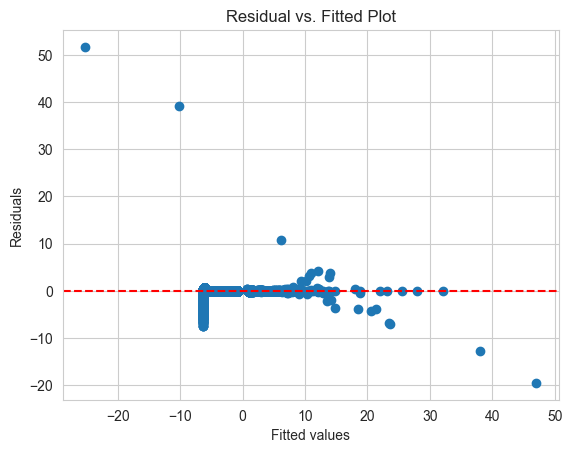

In [58]:
# Check residuals
residuals = model_c.resid
fitted_values = model_c.fittedvalues

# Plotting the residuals
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

<a id="final_summary"></a>
# Final Summary of Causal Analysis on Game Design Impact

### Key Findings
- **Engagement (`n13`)**: Design A generally results in higher engagement, especially among players with initially lower levels of engagement. The interaction term suggests that the negative impact of design B on engagement decreases as initial engagement increases.
- **Monetization (`n14`)**: Design B appears to increase monetization compared to design A. However, the positive impact diminishes with increasing initial engagement, indicated by the negative interaction term.

### Interpretation and Concerns
- **Engagement**: The effectiveness of Design A in increasing engagement makes it suitable for broad application across the player base. However, the positive interaction term (`treatment_n1_daily`) for Design B could indicate a potential threshold of `n1` beyond which Design B could outperform Design A in terms of engagement. Identifying this threshold would be crucial for targeting the right player segments with the appropriate game design.
- **Monetization**: While Design B initially appears to enhance monetization, there are critical nuances and limitations to consider:
  - **Non-Random Selection and High Engagement in Group B**: The players in group B were selected with inherently higher levels of engagement, which typically correlates with higher spending. This selection bias must be acknowledged as it can influence the interpretation of Design B's effectiveness in boosting monetization.
  - **Extrapolation Concerns**: There is uncertainty about whether the positive monetization effect of Design B can be extended to players with very low engagement levels (`n1`). It's plausible that there exists a threshold of engagement below which players will not be motivated to spend regardless of the game design.

### Conclusion
The choice of game design should be aligned with the game’s strategic goals:
- **For Engagement**: Design A is recommended due to its broad effectiveness.
- **For Monetization**: The perceived benefits of Design B require cautious interpretation, particularly considering its efficacy may not hold for players with low engagement. Further investigation is advised to confirm these findings across the full spectrum of player engagement levels.

Given the overall analysis and considering that the majority of the player base has lower levels of initial engagement (n1), if a single design must be chosen for all players, **Design A is recommended.**

## Causal ML: Causal Inference with Machine Learning

Traditional regression methods explored above estimate the Average Treatment Effect (ATE) of game designs, which measure the overall impact of design changes across all players. However, these methods might not fully capture the diverse responses from individual players due to their assumption of uniform effects across the population.

Causal Inference methods, particularly through Causal Machine Learning, offer advanced capabilities:
- **Conditional Average Treatment Effect (CATE)**: Unlike ATE, CATE allows us to understand how the effects of a treatment vary among different subgroups or at individual levels based on observable characteristics. This enables more personalized and effective game design strategies.
- **Complex Interactions**: Machine learning models are adept at capturing complex interactions and nonlinear relationships that traditional models might miss.
- **Heterogeneous Effects**: These models excel at identifying varied treatment effects across different player segments, offering deeper insights into which design elements work best for specific groups.
- **Precision in Targeting**: By accurately identifying the most effective designs for specific player profiles, developers can tailor gaming experiences to optimize engagement and revenue.

Below I explore Causal ML methods, using the `econML` package, to compare and enhance the estimates of treatment effects derived from earlier regression analyses. This approach will form the basis of the modeling strategy I use for Task 2. 

## Estimating the CATE with Causal Machine Learning

In [82]:
# EconML imports
from econml.dr import LinearDRLearner
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [83]:
# Define the treatment (T), outcome (Y), covariates (X), and other controls (W)

T = (df['player_group'] == 'B').astype(int)  # Treatment indicator: 1 for group B, 0 for group A
Y_engagement = df["n13_daily"]  
X_engagement = df[["n1_daily"]] # Assuming n1 only has heterogeneous treatment effect
W_engagement = df[["n7", "n11", "n6"]] # additional covariates

# Initialize DR model
# model_engagement = LinearDRLearner(model_regression=XGBRegressor(),
#                                    model_propensity=XGBClassifier())

model_engagement = LinearDRLearner()

# Train both DR models
model_engagement.fit(Y=Y_engagement, T=T, X=X_engagement, W=W_engagement, inference='statsmodels')

In [84]:
model_engagement.summary(1)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
n1_daily,0.006,0.003,1.734,0.083,-0.001,0.012
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.041,0.024,-1.724,0.085,-0.088,0.006


In [85]:
# Estimate treatment effects on n13
effects_engagement = model_engagement.effect(X_engagement)
df['effects_n13'] = effects_engagement

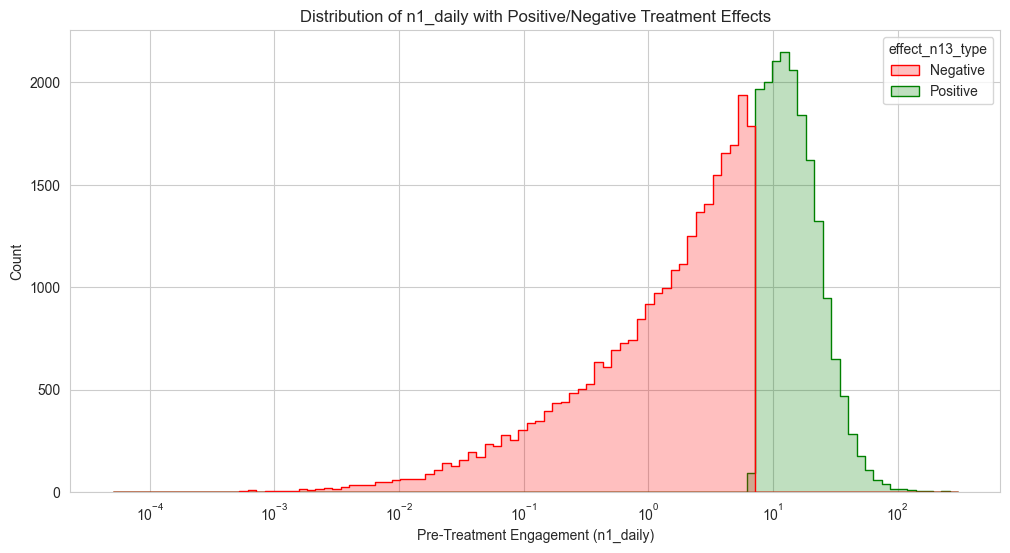

In [86]:
# First, add a new column to categorize the effects as positive or negative
df['effect_n13_type'] = df['effects_n13'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='n1_daily', hue='effect_n13_type', element='step', palette={'Positive': 'green', 'Negative': 'red'}, bins=100, log_scale=True)
plt.title('Distribution of n1_daily with Positive/Negative Treatment Effects')
plt.xlabel('Pre-Treatment Engagement (n1_daily)')
plt.ylabel('Count')
# plt.legend(title='Treatment Effect')
plt.grid(True)
plt.show()

In [87]:
model_engagement.ate(X_engagement, T0=0, T1=1)

0.0025860779571026545

### Summary of CATE model vs Regression results

This positive ATE, despite the previously observed general negative impact of design B at baseline levels, suggests substantial heterogeneity in player responses, with certain subgroups, particularly highly engaged players, responding positively to design B. The positive ATE shows that for some subgroups or individuals, the effect of treatment B is sufficiently positive to raise the average effect across all players. This implies significant heterogeneity in how players respond to the design changes.

Both the DoubleRobustLearner and regression analysis indicate that treatment B generally reduces player engagement compared to treatment A. However, both methods reveal that this negative effect is less pronounced for players with higher initial engagement (n1_daily), suggesting a possible positive effect of treatment B for highly engaged players. 


## Sensitivity Analysis

Assuming that n10=inf represents errors/true outliers, we remove those rows and repeat analysis. 

In [172]:
df_no_inf = df[df['n10'] != np.inf]

In [182]:
### Regression with n10=inf outliers removed 

# Set up the regression model with n13 as the dependent variable
X = df_no_inf[['n1_daily', 'treatment_group', 'treatment_n1_daily', 'n7', 'n6', 'n8', 'n11']]  # Include other covariates as necessary
y = df_no_inf['n13_daily']
X = sm.add_constant(X) 

model_no_inf = sm.OLS(y, X)
results = model_no_inf.fit()

# 
# # Print out the summary of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              n13_daily   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.620e+07
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        14:03:28   Log-Likelihood:                 51345.
No. Observations:               49707   AIC:                        -1.027e+05
Df Residuals:                   49699   BIC:                        -1.026e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1756      0

In [193]:
# Set up the regression model with n14 as the dependent variable
X = df_no_inf[['n1_daily', 'treatment_group', 'treatment_n1_daily', 'treatment_n11', 'n7', 'n6', 'n8', 'n11']]  # Include other covariates as necessary
y = df_no_inf['log_n14']
X = sm.add_constant(X) 

model_no_inf = sm.RLM(y, X)
results = model_no_inf.fit()

# 
# # Print out the summary of the regression model
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                log_n14   No. Observations:                49707
Model:                            RLM   Df Residuals:                    49698
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 12 May 2024                                         
Time:                        14:08:51                                         
No. Iterations:                    50                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.3482      0

## Regression Discontinuity Design

In [69]:
df.groupby('player_group')['n1_daily'].describe()

,count,mean,std,min,25%,50%,75%,max
player_group,,,,,,,,
A,35280.0,2.592204,2.668224,-0.033333,0.253259,1.610116,4.432665,9.205804
B,14720.0,19.554706,13.279369,9.206072,12.102571,15.995300,22.448554,304.928000


In [70]:
df_clean = df.copy()

cutoff = max(df_clean[df_clean['player_group'] == 'A']['n1_daily'])

below_cutoff_df = df_clean[df_clean['n1_daily']<=cutoff]
above_cutoff_df = df_clean[df_clean['n1_daily']>cutoff]

In [71]:
df['treatment'] = (df['n1_daily'] >= cutoff).astype(int)
df['n1_daily__'] = df['n1_daily'] - cutoff  # Centering around the cutoff
df['treat_interaction'] = df['n1_daily__'] * df['treatment']

# Fitting the RDD model
model_rdd = smf.ols('n13_daily ~ n1_daily__ + treatment + treat_interaction + n6 + n7 + n8 + n11 + c2', data=df).fit()
print(model_rdd.summary())

                            OLS Regression Results                            
Dep. Variable:              n13_daily   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.859e+07
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        01:15:59   Log-Likelihood:                 39957.
No. Observations:               44943   AIC:                        -7.989e+04
Df Residuals:                   44932   BIC:                        -7.980e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.4479      0.00

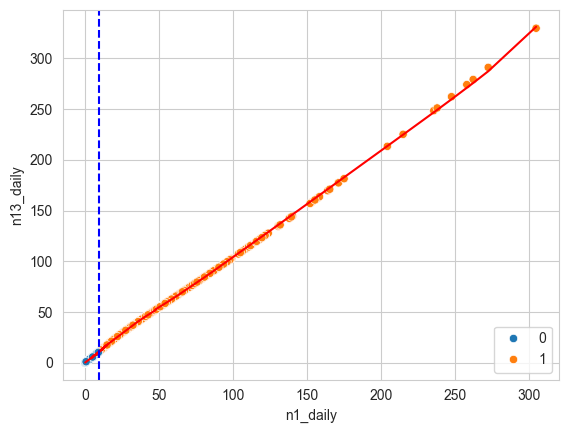

In [72]:
sns.scatterplot(x='n1_daily', y='n13_daily', hue='treatment', data=df)
sns.lineplot(x='n1_daily', y=model_rdd.fittedvalues, color='red', data=df)
plt.axvline(x=cutoff, color='blue', linestyle='--')  # Cutoff line
plt.show()

In [73]:
# Using rdd package
from rdd import rdd

# Restrict dataset to only observations within a certain bandwidth around the threshold cutoff
bandwidth_opt = rdd.optimal_bandwidth(df_clean['n13_daily'], df_clean['n1_daily'], cut=cutoff)
print("Optimal bandwidth:", bandwidth_opt)
print("n1_daily cutoff:", cutoff)

Optimal bandwidth: 2.3236857755198503
n1_daily cutoff: 9.205803633333334


In [74]:
data_rdd = rdd.truncated_data(df_clean, 'n1_daily', bandwidth_opt, cut=cutoff)
data_rdd

,id,c1,c2,c3,c4,c5,c6,player_group,n1,n2,...,n13_daily,treatment_group,treatment_n1_daily,log_n11,log_n13_daily,log_n1_daily,treatment_log_n1_daily,n1_squared,treatment_n1_squared,log_n14
1,1,QVI,aW9z,cHQ,aHVhd,True,KzAzOjAw,B,288.359771,1028.901212,...,11.136052,1,9.611992,1.377567,2.496181,2.361985,2.361985,92.390397,92.390397,-1.682498
5,5,Vk4,aW9z,ZXM,NaN,True,LTA1OjAw,A,221.551160,780.850946,...,8.427588,0,0.000000,1.028837,2.243640,2.126449,0.000000,54.538796,0.000000,-2.085588
25,25,Vk4,aW9z,ZXM,NaN,True,LTA1OjAw,A,216.383334,761.790320,...,8.222878,0,0.000000,1.001938,2.221687,2.105691,0.000000,52.024164,0.000000,-2.118923
39,39,VEg,aW9z,ZnI,NaN,True,KzAzOjAw,A,254.516384,902.891514,...,9.751223,0,0.000000,1.200925,2.375019,2.249593,0.000000,71.976211,0.000000,-1.880951
42,42,Q0E,aW9z,ZnI,aHVhd,True,KzAzOjAw,A,270.132481,960.952409,...,10.387485,0,0.000000,1.282510,2.432515,2.303027,0.000000,81.079508,0.000000,-1.788110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49976,49976,SUQ,aW9z,ZnI,NaN,True,KzAzOjAw,A,231.015213,815.809662,...,8.804559,0,0.000000,1.078174,2.282847,2.163381,0.000000,59.297810,0.000000,-2.025484
49982,49982,VEg,aW9z,ZnI,aHVhd,True,KzAzOjAw,A,259.633261,921.899724,...,9.959129,0,0.000000,1.227665,2.394173,2.267418,0.000000,74.899367,0.000000,-1.850268
49990,49990,Vk4,aW9z,ZXM,NaN,True,LTA1OjAw,A,225.784499,796.480029,...,8.595885,0,0.000000,1.050896,2.261334,2.143138,0.000000,56.642933,0.000000,-2.058557
49994,49994,Vk4,aW9z,ZXM,NaN,True,KzAzOjAw,A,230.254507,812.997304,...,8.774162,0,0.000000,1.074206,2.279742,2.160463,0.000000,58.907931,0.000000,-2.030278


In [75]:
model_rdd_n13 = rdd.rdd(data_rdd, 'n1_daily', 'n13_daily', cut=cutoff, controls=['treatment_n1_daily', 'n6', 'n7', 'n11', 'n8'])
print(model_rdd_n13.fit().summary())

Estimation Equation:	 n13_daily ~ TREATED + n1_daily + treatment_n1_daily + n6 + n7 + n11 + n8
                            WLS Regression Results                            
Dep. Variable:              n13_daily   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.344e+10
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        01:16:29   Log-Likelihood:                 42061.
No. Observations:                6654   AIC:                        -8.411e+04
Df Residuals:                    6646   BIC:                        -8.405e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

## Comparative Analysis of RDD and Standard Regression Results

Standard Regression Model: Indicates a negative association between the treatment (being in group B) and the outcome, suggesting that, on average, group B is associated with lower outcomes compared to group A. This is an average effect across the entire range of n1 and other features.

Regression Discontinuity Design (RDD) Model: Reveals a positive treatment effect at the cutoff point of n1_daily. This suggests that at this specific threshold, receiving the treatment (being in group B) actually results in higher outcomes. Additionally, the positive treatment interaction term suggests that the treatment effect increases with higher n1_daily values around this cutoff.
